In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

In [ ]:
import plotly 
import plotly.express as px
import plotly.graph_objs as go
import plotly.offline as py
from plotly.offline import iplot
from plotly.subplots import make_subplots
import plotly.figure_factory as ff

In [ ]:
df = pd.read_csv('udemy_courses.csv')
df.head()

,course_id,course_title,url,is_paid,price,num_subscribers,num_reviews,num_lectures,level,content_duration,published_timestamp,subject
0,1070968,Ultimate Investment Banking Course,https://www.udemy.com/ultimate-investment-bank...,True,200,2147,23,51,All Levels,1.5,2017-01-18T20:58:58Z,Business Finance
1,1113822,Complete GST Course & Certification - Grow You...,https://www.udemy.com/goods-and-services-tax/,True,75,2792,923,274,All Levels,39.0,2017-03-09T16:34:20Z,Business Finance
2,1006314,Financial Modeling for Business Analysts and C...,https://www.udemy.com/financial-modeling-for-b...,True,45,2174,74,51,Intermediate Level,2.5,2016-12-19T19:26:30Z,Business Finance
3,1210588,Beginner to Pro - Financial Analysis in Excel ...,https://www.udemy.com/complete-excel-finance-c...,True,95,2451,11,36,All Levels,3.0,2017-05-30T20:07:24Z,Business Finance
4,1011058,How To Maximize Your Profits Trading Options,https://www.udemy.com/how-to-maximize-your-pro...,True,200,1276,45,26,Intermediate Level,2.0,2016-12-13T14:57:18Z,Business Finance


In [ ]:
df.columns

Index(['course_id', 'course_title', 'url', 'is_paid', 'price',
       'num_subscribers', 'num_reviews', 'num_lectures', 'level',
       'content_duration', 'published_timestamp', 'subject'],
      dtype='object')

# EDA

In [ ]:
index_vals = df['level'].astype('category').cat.codes
fig = go.Figure(data=go.Splom(
                dimensions=[dict(label='price',
                                 values=df['price']),
                            dict(label='num_subscribers',
                                 values=df['num_subscribers']),
                            dict(label='num_reviews',
                                 values=df['num_reviews']),
                            dict(label='num_lectures',
                                 values=df['num_lectures']),
                           dict(label='content_duration',
                                 values=df['content_duration'])],
                showupperhalf=False, 
                text=df['level'],
                marker=dict(color=index_vals,
                            showscale=False, # colors encode categorical variables
                            line_color='white', line_width=0.5)
                ))


fig.update_layout(
    title='UDEMY Courses',
    width=300,
    height=1000,
)

fig.show()

Based on the results:

There is positive but not so strong relationship between number of reviews and number of subscribers
Also there is positive and almost strong (.80) relationship between number of lectures in the course and the duration of the course.

In [ ]:
df['date'] = pd.to_datetime(df['published_timestamp'])
df['year']= df['date'].dt.year
subject_by_year = df.groupby('year')['subject'].value_counts().reset_index(level=0).rename(columns={'subject': 'subject count'}, index={'index': 'Subject'})
fig = px.line(subject_by_year, x='year', y='subject count', color= subject_by_year.index, title='UDEMY Courses By Subject in Each Year')
fig.show()

From the line plot we can see that Udemy courses on the Web Development and Business Finance significantly increased till 2015
Number of Business Finance related courses stay almost same in 2016 but Web Development related courses continued to increase significantly.

In [ ]:
level_by_year = df.groupby('year')['level'].value_counts().reset_index(level=0).rename(columns={'level': 'level count'}, index={'index': 'Level_of_Courses'})
fig = px.line(level_by_year, x='year', y='level count', color= level_by_year.index, title='UDEMY Courses By Level in Each Year')
fig.show()

The number of expert level courses offered by UDEMY are inconsistent.

Generally speaking, beginner levels and intermediate levels increased significantly by each year

In [ ]:
top_15_paid_courses = df[df['price']!=0][['course_title','year','subject','num_subscribers']].sort_values(by= 'num_subscribers',ascending=False).head(15)
top_15_paid_courses

,course_title,year,subject,num_subscribers
3230,The Web Developer Bootcamp,2015,Web Development,121584
3232,The Complete Web Developer Course 2.0,2016,Web Development,114512
2619,Learn Javascript & JQuery From Scratch,2013,Web Development,84897
3247,JavaScript: Understanding the Weird Parts,2015,Web Development,79612
1979,Pianoforall - Incredible New Way To Learn Pian...,2014,Musical Instruments,75499
3204,Angular 4 (formerly Angular 2) - The Complete ...,2016,Web Development,73783
2701,Become a Web Developer from Scratch,2011,Web Development,69186
3246,Learn and Understand AngularJS,2014,Web Development,59361
3251,Learn and Understand NodeJS,2015,Web Development,58208
2662,The Complete HTML & CSS Course - From Novice T...,2015,Web Development,57422


In [ ]:
fig = px.bar(top_15_paid_courses, y= 'num_subscribers', x='course_title', hover_data = top_15_paid_courses[['year','subject']], color='subject', title='top 15 paid class')
fig.update_layout(xaxis={'categoryorder':'total descending'})
fig.show()

In [ ]:
top_15_free_courses = df[df['price']==0][['course_title','year','subject','num_subscribers']].sort_values(by= 'num_subscribers',ascending=False).head(15)
top_15_free_courses
fig = px.bar(top_15_free_courses, y= 'num_subscribers', x='course_title', hover_data = top_15_free_courses[['year','subject']], color='subject', title='top 15 free class')
fig.update_layout(xaxis={'categoryorder':'total descending'})
fig.show()

## Goal: To predict the number of subscribers:

### drop irrelevant columns: course id, url

In [ ]:
df = df.drop(columns=['course_id','url'])
df

,course_title,is_paid,price,num_subscribers,num_reviews,num_lectures,level,content_duration,published_timestamp,subject
0,Ultimate Investment Banking Course,True,200,2147,23,51,All Levels,1.5,2017-01-18T20:58:58Z,Business Finance
1,Complete GST Course & Certification - Grow You...,True,75,2792,923,274,All Levels,39.0,2017-03-09T16:34:20Z,Business Finance
2,Financial Modeling for Business Analysts and C...,True,45,2174,74,51,Intermediate Level,2.5,2016-12-19T19:26:30Z,Business Finance
3,Beginner to Pro - Financial Analysis in Excel ...,True,95,2451,11,36,All Levels,3.0,2017-05-30T20:07:24Z,Business Finance
4,How To Maximize Your Profits Trading Options,True,200,1276,45,26,Intermediate Level,2.0,2016-12-13T14:57:18Z,Business Finance
...,...,...,...,...,...,...,...,...,...,...
3673,Learn jQuery from Scratch - Master of JavaScri...,True,100,1040,14,21,All Levels,2.0,2016-06-14T17:36:46Z,Web Development
3674,How To Design A WordPress Website With No Codi...,True,25,306,3,42,Beginner Level,3.5,2017-03-10T22:24:30Z,Web Development
3675,Learn and Build using Polymer,True,40,513,169,48,All Levels,3.5,2015-12-30T16:41:42Z,Web Development
3676,CSS Animations: Create Amazing Effects on Your...,True,50,300,31,38,All Levels,3.0,2016-08-11T19:06:15Z,Web Development


Label categorical data:  
paid     -- 1  
non paid -- 0

In [ ]:
for i in range(len(df)):
  if df['is_paid'][i] == True:
    df.loc[i,'is_paid'] = 1
  else:
    df.loc[i,'is_paid'] = 0

df

,course_title,is_paid,price,num_subscribers,num_reviews,num_lectures,level,content_duration,published_timestamp,subject
0,Ultimate Investment Banking Course,1,200,2147,23,51,All Levels,1.5,2017-01-18T20:58:58Z,Business Finance
1,Complete GST Course & Certification - Grow You...,1,75,2792,923,274,All Levels,39.0,2017-03-09T16:34:20Z,Business Finance
2,Financial Modeling for Business Analysts and C...,1,45,2174,74,51,Intermediate Level,2.5,2016-12-19T19:26:30Z,Business Finance
3,Beginner to Pro - Financial Analysis in Excel ...,1,95,2451,11,36,All Levels,3.0,2017-05-30T20:07:24Z,Business Finance
4,How To Maximize Your Profits Trading Options,1,200,1276,45,26,Intermediate Level,2.0,2016-12-13T14:57:18Z,Business Finance
...,...,...,...,...,...,...,...,...,...,...
3673,Learn jQuery from Scratch - Master of JavaScri...,1,100,1040,14,21,All Levels,2.0,2016-06-14T17:36:46Z,Web Development
3674,How To Design A WordPress Website With No Codi...,1,25,306,3,42,Beginner Level,3.5,2017-03-10T22:24:30Z,Web Development
3675,Learn and Build using Polymer,1,40,513,169,48,All Levels,3.5,2015-12-30T16:41:42Z,Web Development
3676,CSS Animations: Create Amazing Effects on Your...,1,50,300,31,38,All Levels,3.0,2016-08-11T19:06:15Z,Web Development


Label categorical data:  
all -- 0  
beginner -- 1  
intermediate -- 2  
expert -- 3

In [ ]:
for i in range(len(df)):
  if df['level'][i] == 'All Levels':
    df.loc[i,'level'] = 0
  elif df['level'][i] == 'Beginner Level':
    df.loc[i,'level'] = 1
  elif df['level'][i] == 'Intermediate Level':
    df.loc[i,'level'] = 2
  else:
    df.loc[i,'level'] = 3

df

,course_title,is_paid,price,num_subscribers,num_reviews,num_lectures,level,content_duration,published_timestamp,subject
0,Ultimate Investment Banking Course,1,200,2147,23,51,0,1.5,2017-01-18T20:58:58Z,Business Finance
1,Complete GST Course & Certification - Grow You...,1,75,2792,923,274,0,39.0,2017-03-09T16:34:20Z,Business Finance
2,Financial Modeling for Business Analysts and C...,1,45,2174,74,51,2,2.5,2016-12-19T19:26:30Z,Business Finance
3,Beginner to Pro - Financial Analysis in Excel ...,1,95,2451,11,36,0,3.0,2017-05-30T20:07:24Z,Business Finance
4,How To Maximize Your Profits Trading Options,1,200,1276,45,26,2,2.0,2016-12-13T14:57:18Z,Business Finance
...,...,...,...,...,...,...,...,...,...,...
3673,Learn jQuery from Scratch - Master of JavaScri...,1,100,1040,14,21,0,2.0,2016-06-14T17:36:46Z,Web Development
3674,How To Design A WordPress Website With No Codi...,1,25,306,3,42,1,3.5,2017-03-10T22:24:30Z,Web Development
3675,Learn and Build using Polymer,1,40,513,169,48,0,3.5,2015-12-30T16:41:42Z,Web Development
3676,CSS Animations: Create Amazing Effects on Your...,1,50,300,31,38,0,3.0,2016-08-11T19:06:15Z,Web Development


### Only use year, month and day for date column:

In [ ]:
for i in range(len(df)):
  df.loc[i,'published_timestamp'] = df.loc[i,'published_timestamp'][:10]

df

,course_title,is_paid,price,num_subscribers,num_reviews,num_lectures,level,content_duration,published_timestamp,subject
0,Ultimate Investment Banking Course,1,200,2147,23,51,0,1.5,2017-01-18,Business Finance
1,Complete GST Course & Certification - Grow You...,1,75,2792,923,274,0,39.0,2017-03-09,Business Finance
2,Financial Modeling for Business Analysts and C...,1,45,2174,74,51,2,2.5,2016-12-19,Business Finance
3,Beginner to Pro - Financial Analysis in Excel ...,1,95,2451,11,36,0,3.0,2017-05-30,Business Finance
4,How To Maximize Your Profits Trading Options,1,200,1276,45,26,2,2.0,2016-12-13,Business Finance
...,...,...,...,...,...,...,...,...,...,...
3673,Learn jQuery from Scratch - Master of JavaScri...,1,100,1040,14,21,0,2.0,2016-06-14,Web Development
3674,How To Design A WordPress Website With No Codi...,1,25,306,3,42,1,3.5,2017-03-10,Web Development
3675,Learn and Build using Polymer,1,40,513,169,48,0,3.5,2015-12-30,Web Development
3676,CSS Animations: Create Amazing Effects on Your...,1,50,300,31,38,0,3.0,2016-08-11,Web Development


### dataset was released on 2020-05-16, we change the timestamp column to the number of days between published date and released date:

In [ ]:
released = ['2020-05-16' for i in range(len(df))]
df['released'] = released
df

,course_title,is_paid,price,num_subscribers,num_reviews,num_lectures,level,content_duration,published_timestamp,subject,released
0,Ultimate Investment Banking Course,1,200,2147,23,51,0,1.5,2017-01-18,Business Finance,2020-05-16
1,Complete GST Course & Certification - Grow You...,1,75,2792,923,274,0,39.0,2017-03-09,Business Finance,2020-05-16
2,Financial Modeling for Business Analysts and C...,1,45,2174,74,51,2,2.5,2016-12-19,Business Finance,2020-05-16
3,Beginner to Pro - Financial Analysis in Excel ...,1,95,2451,11,36,0,3.0,2017-05-30,Business Finance,2020-05-16
4,How To Maximize Your Profits Trading Options,1,200,1276,45,26,2,2.0,2016-12-13,Business Finance,2020-05-16
...,...,...,...,...,...,...,...,...,...,...,...
3673,Learn jQuery from Scratch - Master of JavaScri...,1,100,1040,14,21,0,2.0,2016-06-14,Web Development,2020-05-16
3674,How To Design A WordPress Website With No Codi...,1,25,306,3,42,1,3.5,2017-03-10,Web Development,2020-05-16
3675,Learn and Build using Polymer,1,40,513,169,48,0,3.5,2015-12-30,Web Development,2020-05-16
3676,CSS Animations: Create Amazing Effects on Your...,1,50,300,31,38,0,3.0,2016-08-11,Web Development,2020-05-16


In [ ]:
df['released'] = pd.to_datetime(df['released'])
df['published_timestamp'] = pd.to_datetime(df['published_timestamp'])
df['days'] = ((df.released - df.published_timestamp)/np.timedelta64(1, 'D'))
df

,course_title,is_paid,price,num_subscribers,num_reviews,num_lectures,level,content_duration,published_timestamp,subject,released,days
0,Ultimate Investment Banking Course,1,200,2147,23,51,0,1.5,2017-01-18,Business Finance,2020-05-16,1214.0
1,Complete GST Course & Certification - Grow You...,1,75,2792,923,274,0,39.0,2017-03-09,Business Finance,2020-05-16,1164.0
2,Financial Modeling for Business Analysts and C...,1,45,2174,74,51,2,2.5,2016-12-19,Business Finance,2020-05-16,1244.0
3,Beginner to Pro - Financial Analysis in Excel ...,1,95,2451,11,36,0,3.0,2017-05-30,Business Finance,2020-05-16,1082.0
4,How To Maximize Your Profits Trading Options,1,200,1276,45,26,2,2.0,2016-12-13,Business Finance,2020-05-16,1250.0
...,...,...,...,...,...,...,...,...,...,...,...,...
3673,Learn jQuery from Scratch - Master of JavaScri...,1,100,1040,14,21,0,2.0,2016-06-14,Web Development,2020-05-16,1432.0
3674,How To Design A WordPress Website With No Codi...,1,25,306,3,42,1,3.5,2017-03-10,Web Development,2020-05-16,1163.0
3675,Learn and Build using Polymer,1,40,513,169,48,0,3.5,2015-12-30,Web Development,2020-05-16,1599.0
3676,CSS Animations: Create Amazing Effects on Your...,1,50,300,31,38,0,3.0,2016-08-11,Web Development,2020-05-16,1374.0


# New Section

### change days to int and drop released & timestamp:

In [ ]:
df['days'] = df['days'].astype(int)
df = df.drop(columns=['published_timestamp','released'])
df

,course_title,is_paid,price,num_subscribers,num_reviews,num_lectures,level,content_duration,subject,days
0,Ultimate Investment Banking Course,1,200,2147,23,51,0,1.5,Business Finance,1214
1,Complete GST Course & Certification - Grow You...,1,75,2792,923,274,0,39.0,Business Finance,1164
2,Financial Modeling for Business Analysts and C...,1,45,2174,74,51,2,2.5,Business Finance,1244
3,Beginner to Pro - Financial Analysis in Excel ...,1,95,2451,11,36,0,3.0,Business Finance,1082
4,How To Maximize Your Profits Trading Options,1,200,1276,45,26,2,2.0,Business Finance,1250
...,...,...,...,...,...,...,...,...,...,...
3673,Learn jQuery from Scratch - Master of JavaScri...,1,100,1040,14,21,0,2.0,Web Development,1432
3674,How To Design A WordPress Website With No Codi...,1,25,306,3,42,1,3.5,Web Development,1163
3675,Learn and Build using Polymer,1,40,513,169,48,0,3.5,Web Development,1599
3676,CSS Animations: Create Amazing Effects on Your...,1,50,300,31,38,0,3.0,Web Development,1374


### one hot encode subject column since it's orderless:

In [ ]:
dummy = pd.get_dummies(df['subject'])
df = df.drop(columns=['subject'])
df = pd.concat([df, dummy], axis=1)
df

,course_title,is_paid,price,num_subscribers,num_reviews,num_lectures,level,content_duration,days,Business Finance,Graphic Design,Musical Instruments,Web Development
0,Ultimate Investment Banking Course,1,200,2147,23,51,0,1.5,1214,1,0,0,0
1,Complete GST Course & Certification - Grow You...,1,75,2792,923,274,0,39.0,1164,1,0,0,0
2,Financial Modeling for Business Analysts and C...,1,45,2174,74,51,2,2.5,1244,1,0,0,0
3,Beginner to Pro - Financial Analysis in Excel ...,1,95,2451,11,36,0,3.0,1082,1,0,0,0
4,How To Maximize Your Profits Trading Options,1,200,1276,45,26,2,2.0,1250,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3673,Learn jQuery from Scratch - Master of JavaScri...,1,100,1040,14,21,0,2.0,1432,0,0,0,1
3674,How To Design A WordPress Website With No Codi...,1,25,306,3,42,1,3.5,1163,0,0,0,1
3675,Learn and Build using Polymer,1,40,513,169,48,0,3.5,1599,0,0,0,1
3676,CSS Animations: Create Amazing Effects on Your...,1,50,300,31,38,0,3.0,1374,0,0,0,1


### Preprocessing done, start model building:

In [ ]:
y = df['num_subscribers']
X = df.drop(columns=['num_subscribers','course_title'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

### RF regressor:

RMSE: 3703.333492338694 



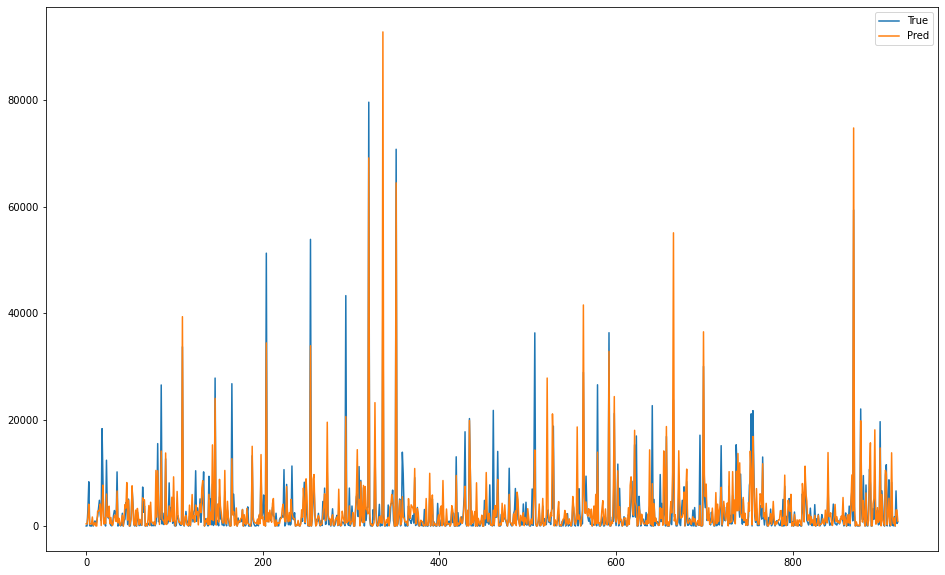

In [ ]:
rf = RandomForestRegressor(n_estimators=10, max_depth=20, random_state=42)
rf.fit(X_train, y_train)
pred = rf.predict(X_test)
rmse = mean_squared_error(y_test, pred, squared=False)
print('RMSE:',rmse,'\n')
plt.figure(figsize=(16, 10))
plt.plot([i for i in range(len(y_test))],y_test, label='True')
plt.plot([i for i in range(len(pred))], pred, label='Pred')
plt.legend()
plt.show()

In [ ]:
X_train

,is_paid,price,num_reviews,num_lectures,level,content_duration,days,Business Finance,Graphic Design,Musical Instruments,Web Development
812,1,20,7,13,1,0.533333,1569,1,0,0,0
2643,1,195,292,178,0,13.000000,1247,0,0,0,1
2164,1,80,14,39,1,3.000000,1662,0,0,1,0
2664,1,150,88,68,0,5.500000,1737,0,0,0,1
1071,1,40,2,37,1,3.500000,1747,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
1130,0,0,71,26,0,1.500000,1363,1,0,0,0
1294,1,40,92,25,0,10.000000,2964,0,1,0,0
860,1,50,12,26,0,3.000000,1776,1,0,0,0
3507,0,0,319,25,0,2.000000,1803,0,0,0,1


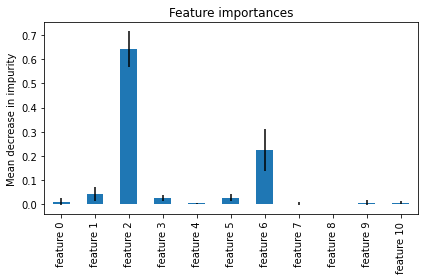

In [ ]:
feature_names = [f"feature {i}" for i in range(X_train.shape[1])]

importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

num_reviews and days are the most important.

### xgboost:

In [ ]:
X_train['is_paid'] = X_train['is_paid'].astype(int)
X_test['is_paid'] = X_test['is_paid'].astype(int)
X_train['level'] = X_train['level'].astype(int)
X_test['level'] = X_test['level'].astype(int)

[21:46:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSE: 5578.934467314185 



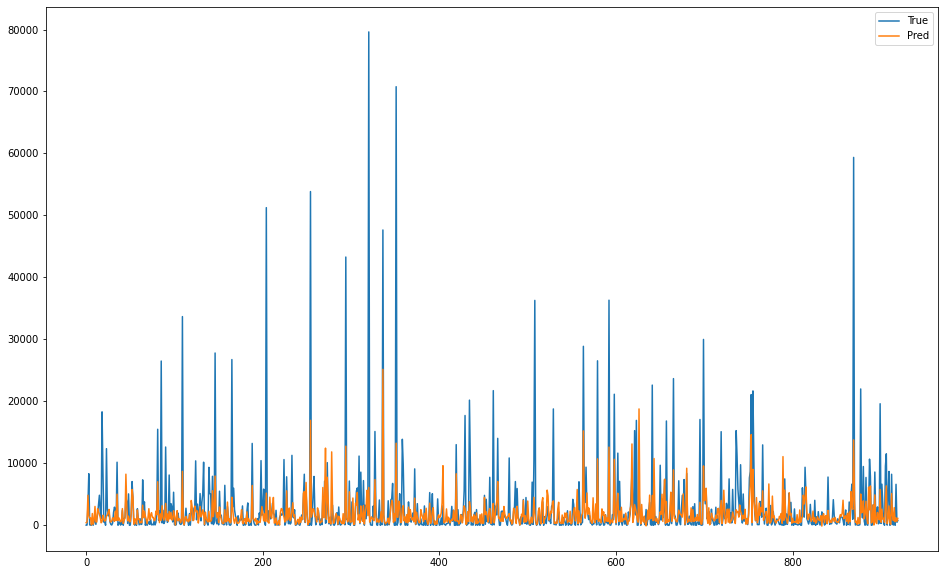

In [ ]:
xgb_r = xgb.XGBRegressor(objective='reg:linear', colsample_bytree=0.3, learning_rate=0.1, max_depth=20, alpha=10, n_estimators=10)
xgb_r.fit(X_train, y_train)
pred = xgb_r.predict(X_test)
rmse = mean_squared_error(y_test, pred, squared=False)
print('RMSE:',rmse,'\n')
plt.figure(figsize=(16, 10))
plt.plot([i for i in range(len(y_test))],y_test, label='True')
plt.plot([i for i in range(len(pred))], pred, label='Pred')
plt.legend()
plt.show()

## Random Forest regressor performs better.